# Processing multiple interferograms with ISCE

In [1]:
# Import required packages
import logging
log = logging.getLogger()
log.setLevel(logging.WARN)
import os
import getpass
import asf_search as asf
import isce
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from osgeo import gdal
from datetime import datetime, timedelta
import xarray as xr
import rasterio as rio
import rioxarray
import geopandas as gpd
import time

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
2023-01-27 00:13:23,190 - matplotlib - DEBUG - matplotlib data path: /home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/matplotlib/mpl-data
2023-01-27 00:13:23,522 - matplotlib - DEBUG - CONFIGDIR=/home/jovyan/.config/matplotlib
2023-01-27 00:13:23,524 - matplotlib - DEBUG - interactive is False
2023-01-27 00:13:23,525 - matplotlib - DEBUG - platform is linux
2023-01-27 00:13:23,762 - matplotlib - DEBUG - CACHEDIR=/home/jovyan/.cache/matplotlib
2023-01-27 00:13:23,766 - matplotlib.font_manager - DEBUG - Using fontManager instance from /home/jovyan/.cache/m

In [2]:
# Set environment variables so that you can call ISCE from the command line
os.environ['ISCE_HOME'] = os.path.dirname(isce.__file__)
os.environ['ISCE_ROOT'] = os.path.dirname(os.environ['ISCE_HOME'])
os.environ['PATH']+='{ISCE_HOME}/bin:{ISCE_HOME}/applications'.format(**os.environ)
print(os.environ['PATH'])

/home/jovyan/.local/ARIA-tools/tools/bin:/home/jovyan/.local/ARIA-tools/tools/ARIAtools:/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/isce/applications:/home/jovyan/.local/envs/insar_analysis/bin:/opt/conda/bin:/opt/conda/condabin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/isce/bin:/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/isce/applications


In [3]:
!which topsApp.py

/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/isce/applications/topsApp.py


In [2]:
scene_list = ['S1A_IW_SLC__1SSV_20150724T130905_20150724T130934_006953_0096A9_46FE',
              'S1A_IW_SLC__1SSV_20150817T130906_20150817T130936_007303_00A04B_63DC',
              'S1A_IW_SLC__1SSV_20150910T130907_20150910T130937_007653_00A9DB_A94D',
              'S1A_IW_SLC__1SSV_20160718T130905_20160718T130935_012203_012F06_90B6',
              'S1A_IW_SLC__1SSV_20160811T130906_20160811T130936_012553_013A96_C2EF',
              'S1A_IW_SLC__1SSV_20160904T130908_20160904T130937_012903_014647_0D62',
              'S1A_IW_SLC__1SDV_20170725T130907_20170725T130934_017628_01D812_AB22',
              'S1A_IW_SLC__1SDV_20170806T130907_20170806T130934_017803_01DD66_D12A',
              'S1A_IW_SLC__1SDV_20170818T130908_20170818T130935_017978_01E2B4_97AF',
              'S1A_IW_SLC__1SDV_20170830T130909_20170830T130936_018153_01E7F9_82F8',
              'S1A_IW_SLC__1SDV_20170911T130909_20170911T130936_018328_01ED72_390F',
              'S1A_IW_SLC__1SDV_20180720T130913_20180720T130940_022878_027B2F_2FE4',
              'S1A_IW_SLC__1SDV_20180801T130914_20180801T130940_023053_0280B9_EF39',
              'S1A_IW_SLC__1SDV_20180813T130916_20180813T130946_023228_028653_F81C',
              'S1A_IW_SLC__1SDV_20180825T130917_20180825T130947_023403_028BF2_E58F',
              'S1A_IW_SLC__1SDV_20180906T130917_20180906T130947_023578_029189_3FCA',
              'S1A_IW_SLC__1SDV_20190715T130920_20190715T130950_028128_032D4E_7792',
              'S1A_IW_SLC__1SDV_20190727T130921_20190727T130951_028303_0332A5_58AD',
              'S1A_IW_SLC__1SDV_20190808T130918_20190808T130944_028478_033802_7E38',
              'S1A_IW_SLC__1SDV_20190820T130918_20190820T130945_028653_033E13_DA5B',
              'S1A_IW_SLC__1SDV_20190901T130919_20190901T130946_028828_03442D_4484',
              'S1A_IW_SLC__1SDV_20190913T130919_20190913T130946_029003_034A3F_5568',
              'S1A_IW_SLC__1SDV_20200721T130923_20200721T130950_033553_03E363_B8F9',
              'S1A_IW_SLC__1SDV_20200802T130924_20200802T130951_033728_03E8C2_6B3A',
              'S1A_IW_SLC__1SDV_20200814T130924_20200814T130951_033903_03EEAD_F614',
              'S1A_IW_SLC__1SDV_20200826T130925_20200826T130952_034078_03F4DE_B501',
              'S1A_IW_SLC__1SDV_20200907T130926_20200907T130953_034253_03FB06_4591',
              'S1A_IW_SLC__1SDV_20210716T130929_20210716T130955_038803_04941E_7251',
              'S1A_IW_SLC__1SDV_20210728T130929_20210728T130956_038978_049956_7D41',
              'S1A_IW_SLC__1SDV_20210809T130930_20210809T130957_039153_049EFA_BFE7',
              'S1A_IW_SLC__1SDV_20210821T130930_20210821T130957_039328_04A504_A838',
              'S1A_IW_SLC__1SDV_20210902T130931_20210902T130958_039503_04AAFA_D28A',
              'S1A_IW_SLC__1SDV_20210914T130932_20210914T130959_039678_04B10F_0E48'
             ]

In [3]:
def select_pairs(scene_list, max_temp_bline):
    scene_dates = {}
    for scene in scene_list:
        date = scene[17:25]
        scene_dates[date] = scene
        
    pair_dict = {}
    pair_scenes = []
    for date1 in scene_dates:
        for date2 in scene_dates:
            if datetime.strptime(date2, '%Y%m%d')-datetime.strptime(date1, '%Y%m%d') < timedelta(days=max_temp_bline) and not date1 >= date2 :
                pair_dict[f'{date1}-{date2}'] = [scene_dates[date1], scene_dates[date2]]
                pair_scenes.append(scene_dates[date1])
                pair_scenes.append(scene_dates[date2])
    pair_scenes = [*set(pair_scenes)]
    
    print(f'number of pairs: {len(pair_dict)}')
    
    return pair_dict, pair_scenes

In [4]:
pair_dict, pair_scenes = select_pairs(scene_list, 40)

number of pairs: 55


In [5]:
proc_path = '/home/jovyan/rmnp_landslide/proc_T56D'
dem_name = 'usgs_10m.dem.wgs84'

In [ ]:
for pair in pair_dict:
    pair_path = f'{proc_path}/{pair}'
    if not os.path.exists(pair_path):
                          os.makedirs(pair_path)
    !cp '{proc_path}/{dem_name}.xml' '{pair_path}/{dem_name}.xml'
    !cp '{proc_path}/{dem_name}' '{pair_path}/{dem_name}'

## Download all SLCs

In [ ]:
EARTHDATA_LOGIN = "qbrencherUW"
EARTHDATA_PASSWORD = getpass.getpass()

In [ ]:
# Change to SLC directory
os.chdir(f'{proc_path}/slc')

logging.getLogger("urllib3").setLevel(logging.WARNING)

results = asf.granule_search(pair_scenes)
session = asf.ASFSession().auth_with_creds(EARTHDATA_LOGIN, EARTHDATA_PASSWORD)
results.download(path=f'{proc_path}/slc', processes=2, session=session)

## Download orbital files

In [ ]:
os.chdir(f'{proc_path}/orbital')

In [ ]:
%%bash

wget -nc https://raw.githubusercontent.com/isce-framework/isce2/main/contrib/stack/topsStack/fetchOrbit.py
chmod +x fetchOrbit.py

In [ ]:
# grab orbital files with fetchOrbit.py
for scene in pair_scenes:
    os.system(f'./fetchOrbit.py -i {scene}')

## Write input files

In [8]:
for pair in pair_dict:
    os.chdir(f'{proc_path}/{pair}')
    
    reference = pair_dict[pair][0]
    secondary = pair_dict[pair][1]
    
    with open('topsApp.xml', 'w') as f:
        f.write(f"""<?xml version="1.0" encoding="UTF-8"?>
    <topsApp>
      <component name="topsinsar">
        <property name="Sensor name">SENTINEL1</property>
        <component name="reference">
            <property name="orbit directory">{proc_path}/orbital</property>
            <property name="output directory">reference</property>
            <property name="safe">{proc_path}/slc/{reference}.zip</property>
        </component>
        <component name="secondary">
            <property name="orbit directory">{proc_path}/orbital</property>
            <property name="output directory">secondary</property>
            <property name="safe">{proc_path}/slc/{secondary}.zip</property>
        </component>
        <property name="demfilename">{proc_path}/usgs_10m.dem.wgs84</property>
        <property name="useGPU">True</property>
        <property name="range looks">6</property>
        <property name="azimuth looks">1</property>
        <property name="swaths">[1]</property>
        <property name="region of interest">[40.30, 40.310, -105.69, -105.67]</property>
        <property name="do esd">False</property>
        <property name="do ionospherecorrection">False</property>
        <property name="do unwrap">True</property>
        <property name="unwrapper name">snaphu_mcf</property>
        <property name="do denseoffsets">False</property>
        <property name="geocode demfilename">{proc_path}/usgs_10m.dem.wgs84</property>
        <property name="geocode list">['merged/topophase.cor', 'merged/filt_topophase.unw', 'merged/filt_topophase.flat']</property>
      </component>
    </topsApp>""")

## TopsApp processing

In [9]:
pair_dict = {
    '20190715-20190808': ['S1A_IW_SLC__1SDV_20190715T130920_20190715T130950_028128_032D4E_7792',
                          'S1A_IW_SLC__1SDV_20190808T130918_20190808T130944_028478_033802_7E38'],
    '20190715-20190820': ['S1A_IW_SLC__1SDV_20190715T130920_20190715T130950_028128_032D4E_7792',
                          'S1A_IW_SLC__1SDV_20190820T130918_20190820T130945_028653_033E13_DA5B'],
    '20190727-20190808': ['S1A_IW_SLC__1SDV_20190727T130921_20190727T130951_028303_0332A5_58AD',
                          'S1A_IW_SLC__1SDV_20190808T130918_20190808T130944_028478_033802_7E38'],
    '20190727-20190820': ['S1A_IW_SLC__1SDV_20190727T130921_20190727T130951_028303_0332A5_58AD',
                          'S1A_IW_SLC__1SDV_20190820T130918_20190820T130945_028653_033E13_DA5B'],
    '20190727-20190901': ['S1A_IW_SLC__1SDV_20190727T130921_20190727T130951_028303_0332A5_58AD',
                          'S1A_IW_SLC__1SDV_20190901T130919_20190901T130946_028828_03442D_4484'],
    '20190808-20190820': ['S1A_IW_SLC__1SDV_20190808T130918_20190808T130944_028478_033802_7E38',
                          'S1A_IW_SLC__1SDV_20190820T130918_20190820T130945_028653_033E13_DA5B'],
    '20190808-20190901': ['S1A_IW_SLC__1SDV_20190808T130918_20190808T130944_028478_033802_7E38',
                          'S1A_IW_SLC__1SDV_20190901T130919_20190901T130946_028828_03442D_4484'],
    '20190808-20190913': ['S1A_IW_SLC__1SDV_20190808T130918_20190808T130944_028478_033802_7E38',
                          'S1A_IW_SLC__1SDV_20190913T130919_20190913T130946_029003_034A3F_5568'],
    '20190820-20190901': ['S1A_IW_SLC__1SDV_20190820T130918_20190820T130945_028653_033E13_DA5B',
                          'S1A_IW_SLC__1SDV_20190901T130919_20190901T130946_028828_03442D_4484'],
    '20190820-20190913': ['S1A_IW_SLC__1SDV_20190820T130918_20190820T130945_028653_033E13_DA5B',
                          'S1A_IW_SLC__1SDV_20190913T130919_20190913T130946_029003_034A3F_5568'],
    '20190901-20190913': ['S1A_IW_SLC__1SDV_20190901T130919_20190901T130946_028828_03442D_4484',
                          'S1A_IW_SLC__1SDV_20190913T130919_20190913T130946_029003_034A3F_5568'],
    '20200721-20200802': ['S1A_IW_SLC__1SDV_20200721T130923_20200721T130950_033553_03E363_B8F9',
                          'S1A_IW_SLC__1SDV_20200802T130924_20200802T130951_033728_03E8C2_6B3A'],
    '20200721-20200814': ['S1A_IW_SLC__1SDV_20200721T130923_20200721T130950_033553_03E363_B8F9',
                          'S1A_IW_SLC__1SDV_20200814T130924_20200814T130951_033903_03EEAD_F614'],
    '20200721-20200826': ['S1A_IW_SLC__1SDV_20200721T130923_20200721T130950_033553_03E363_B8F9',
                          'S1A_IW_SLC__1SDV_20200826T130925_20200826T130952_034078_03F4DE_B501'],
    '20200802-20200814': ['S1A_IW_SLC__1SDV_20200802T130924_20200802T130951_033728_03E8C2_6B3A',
                          'S1A_IW_SLC__1SDV_20200814T130924_20200814T130951_033903_03EEAD_F614'],
    '20200802-20200826': ['S1A_IW_SLC__1SDV_20200802T130924_20200802T130951_033728_03E8C2_6B3A',
                          'S1A_IW_SLC__1SDV_20200826T130925_20200826T130952_034078_03F4DE_B501'],
    '20200802-20200907': ['S1A_IW_SLC__1SDV_20200802T130924_20200802T130951_033728_03E8C2_6B3A',
                          'S1A_IW_SLC__1SDV_20200907T130926_20200907T130953_034253_03FB06_4591'],
    '20200814-20200826': ['S1A_IW_SLC__1SDV_20200814T130924_20200814T130951_033903_03EEAD_F614',
                          'S1A_IW_SLC__1SDV_20200826T130925_20200826T130952_034078_03F4DE_B501'],
    '20200814-20200907': ['S1A_IW_SLC__1SDV_20200814T130924_20200814T130951_033903_03EEAD_F614',
                          'S1A_IW_SLC__1SDV_20200907T130926_20200907T130953_034253_03FB06_4591'],
    '20200826-20200907': ['S1A_IW_SLC__1SDV_20200826T130925_20200826T130952_034078_03F4DE_B501',
                          'S1A_IW_SLC__1SDV_20200907T130926_20200907T130953_034253_03FB06_4591'],
    '20210716-20210728': ['S1A_IW_SLC__1SDV_20210716T130929_20210716T130955_038803_04941E_7251',
                          'S1A_IW_SLC__1SDV_20210728T130929_20210728T130956_038978_049956_7D41'],
    '20210716-20210809': ['S1A_IW_SLC__1SDV_20210716T130929_20210716T130955_038803_04941E_7251',
                          'S1A_IW_SLC__1SDV_20210809T130930_20210809T130957_039153_049EFA_BFE7'],
    '20210716-20210821': ['S1A_IW_SLC__1SDV_20210716T130929_20210716T130955_038803_04941E_7251',
                          'S1A_IW_SLC__1SDV_20210821T130930_20210821T130957_039328_04A504_A838'],
    '20210728-20210809': ['S1A_IW_SLC__1SDV_20210728T130929_20210728T130956_038978_049956_7D41',
                          'S1A_IW_SLC__1SDV_20210809T130930_20210809T130957_039153_049EFA_BFE7'],
    '20210728-20210821': ['S1A_IW_SLC__1SDV_20210728T130929_20210728T130956_038978_049956_7D41',
                          'S1A_IW_SLC__1SDV_20210821T130930_20210821T130957_039328_04A504_A838'],
    '20210728-20210902': ['S1A_IW_SLC__1SDV_20210728T130929_20210728T130956_038978_049956_7D41',
                          'S1A_IW_SLC__1SDV_20210902T130931_20210902T130958_039503_04AAFA_D28A'],
    '20210809-20210821': ['S1A_IW_SLC__1SDV_20210809T130930_20210809T130957_039153_049EFA_BFE7',
                          'S1A_IW_SLC__1SDV_20210821T130930_20210821T130957_039328_04A504_A838'],
    '20210809-20210902': ['S1A_IW_SLC__1SDV_20210809T130930_20210809T130957_039153_049EFA_BFE7',
                          'S1A_IW_SLC__1SDV_20210902T130931_20210902T130958_039503_04AAFA_D28A'],
    '20210809-20210914': ['S1A_IW_SLC__1SDV_20210809T130930_20210809T130957_039153_049EFA_BFE7',
                          'S1A_IW_SLC__1SDV_20210914T130932_20210914T130959_039678_04B10F_0E48'],
    '20210821-20210902': ['S1A_IW_SLC__1SDV_20210821T130930_20210821T130957_039328_04A504_A838',
                          'S1A_IW_SLC__1SDV_20210902T130931_20210902T130958_039503_04AAFA_D28A'],
    '20210821-20210914': ['S1A_IW_SLC__1SDV_20210821T130930_20210821T130957_039328_04A504_A838',
                          'S1A_IW_SLC__1SDV_20210914T130932_20210914T130959_039678_04B10F_0E48'],
    '20210902-20210914': ['S1A_IW_SLC__1SDV_20210902T130931_20210902T130958_039503_04AAFA_D28A',
                          'S1A_IW_SLC__1SDV_20210914T130932_20210914T130959_039678_04B10F_0E48']}

In [ ]:
%%time

for pair in pair_dict:
    os.chdir(f'{proc_path}/{pair}')
    
    !topsApp.py --start=preprocess --end=geocode

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
2022-12-20 17:02:35,019 - isce.insar - INFO - ISCE VERSION = 2.6.1, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20220811, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.6.1, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20220811, CURRENT_SVN_REVISION = 
Step processing
Cannot open PICKLE/startup
Running step preprocess
Input XML files:  ['/vsizip//home/jovyan/rmnp_landslide/proc_T56D/slc/S1A_IW_SLC__1SDV_20190715T130920_20190715T130950_028128_032D4E_7792.zip/S1A_IW_SLC__1SDV_20190715T130920_20190715T130950_028128_032D4E_7792.SAFE/annotation/s1a-iw1-slc-vv-20190715t130920-20190715t130948-028

## Filter and stack interferograms
### Load igrams into xarray

In [6]:
# functions to load interferogram tifs to xarray

def xr_read_vrt(vrt_file_path, variable_name, masked=True):
    
    if os.path.exists(vrt_file_path):
        da = rioxarray.open_rasterio(vrt_file_path, masked=True)

        # Extract phase and assign as variable in xr.Dataset()
        ds = xr.Dataset()
        da_phase = da.sel(band=2)
        da_phase.name = variable_name
        ds[da_phase.name] = da_phase

        # Preserve top-level attributes and extract single value from value iterables e.g. (1,) --> 1
        ds.attrs = da.attrs
        for key, value in ds.attrs.items():
            try:
                if len(value) == 1:
                    ds.attrs[key] = value[0]
            except TypeError:
                pass
    
        # crop to roi
        ds = ds.rio.clip_box(minx=-105.69, miny=40.29, maxx=-105.66, maxy=40.31) 

        return ds
    
    else:
        print('path does not exist')

In [7]:
igram_dss = []
coh_dss = []
igram_name = 'merged/filt_topophase.unw.geo.vrt'
coh_name = 'merged/topophase.cor.geo.vrt'

for pair in pair_dict:
    igram_src = xr_read_vrt(f'{proc_path}/{pair}/{igram_name}', 'unw_phase')
    if igram_src != None:
        igram_src = igram_src.assign_coords({"dates": pair})
        igram_src = igram_src.expand_dims("dates")
        igram_dss.append(igram_src)
                            
        coh_src = xr_read_vrt(f'{proc_path}/{pair}/{coh_name}', 'coherence')
        coh_src = coh_src.assign_coords({"dates": pair})
        coh_src = coh_src.expand_dims("dates")
        coh_dss.append(coh_src)

2023-01-27 00:14:26,692 - rasterio.env - DEBUG - Entering env context: <rasterio.env.Env object at 0x7f4271b88f40>
2023-01-27 00:14:26,695 - rasterio.env - DEBUG - Starting outermost env
2023-01-27 00:14:26,696 - rasterio.env - DEBUG - No GDAL environment exists
2023-01-27 00:14:26,697 - rasterio.env - DEBUG - New GDAL environment <rasterio._env.GDALEnv object at 0x7f4271be1d90> created
2023-01-27 00:14:26,699 - rasterio._filepath - DEBUG - Installing FilePath filesystem handler plugin...
2023-01-27 00:14:26,700 - rasterio._env - DEBUG - GDAL_DATA found in environment.
2023-01-27 00:14:26,701 - rasterio._env - DEBUG - PROJ_DATA found in environment.
2023-01-27 00:14:26,702 - rasterio._env - DEBUG - Started GDALEnv: self=<rasterio._env.GDALEnv object at 0x7f4271be1d90>.
2023-01-27 00:14:26,702 - rasterio.env - DEBUG - Entered env context: <rasterio.env.Env object at 0x7f4271b88f40>
2023-01-27 00:14:26,704 - rasterio._base - DEBUG - Sharing flag: 0
2023-01-27 00:14:27,860 - rasterio._bas

In [8]:
# standardize coordinates before concat
igram_dss_standard = [igram_dss[0]]
coh_dss_standard = []

x_reference = igram_dss[0]['x'].values
y_reference = igram_dss[0]['y'].values

for ds in igram_dss[1:]:
    ds = ds.assign_coords({'x': ('x', x_reference),
                      'y': ('y', y_reference)})
    igram_dss_standard.append(ds)
    
for ds in coh_dss:
    ds = ds.assign_coords({'x': ('x', x_reference),
                      'y': ('y', y_reference)})
    coh_dss_standard.append(ds)
    

igram_ds = xr.concat(igram_dss_standard, dim='dates', combine_attrs="no_conflicts") #create dataset
coh_ds = xr.concat(coh_dss_standard, dim='dates', combine_attrs="no_conflicts") #create dataset
igram_ds['coherence'] = (('dates', 'y', 'x'), coh_ds['coherence'].values)

### Change reference points

In [9]:
# function to find value of new reference point in each time slice and subtract it from data array
rref_list = []

def change_ref(ds, lat, lon):
    reref = ds.copy(deep=True)
    for i in range(ds.sizes['dates']):
        # get value from grid
        rref_list.append(float(ds.isel(dates=i).unw_phase.sel(x=lon, y=lat, method='nearest').values))
    reref['unw_phase'] = ds['unw_phase'] - xr.DataArray(rref_list, dims='dates')
    return reref 

In [10]:
igram_ds = change_ref(igram_ds, 40.302141, -105.685762)

### Convert to velocities in m/yr

In [11]:
delta_list = []
for date in igram_ds['dates'].values:
    delta_list.append((datetime.strptime(date[9:17], '%Y%m%d')-datetime.strptime(date[0:8], '%Y%m%d')).days)
    
igram_ds = igram_ds.assign_coords({'timedelta':('timedelta', delta_list)})

veloc = (((igram_ds['unw_phase']*0.05546576/12.5663706)/igram_ds['timedelta'])*365)[0].values
igram_ds['veloc'] = (('y', 'x', 'dates'), veloc.data)
igram_ds = igram_ds.drop_dims('timedelta')

In [22]:
# f, ax = plt.subplots()
# ax.imshow(igram_ds['veloc'].median(dim="dates"), cmap='RdBu', vmin=-0.4, vmax=0.4) 

### filter and stack

/home/jovyan/.local/envs/insar_analysis/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


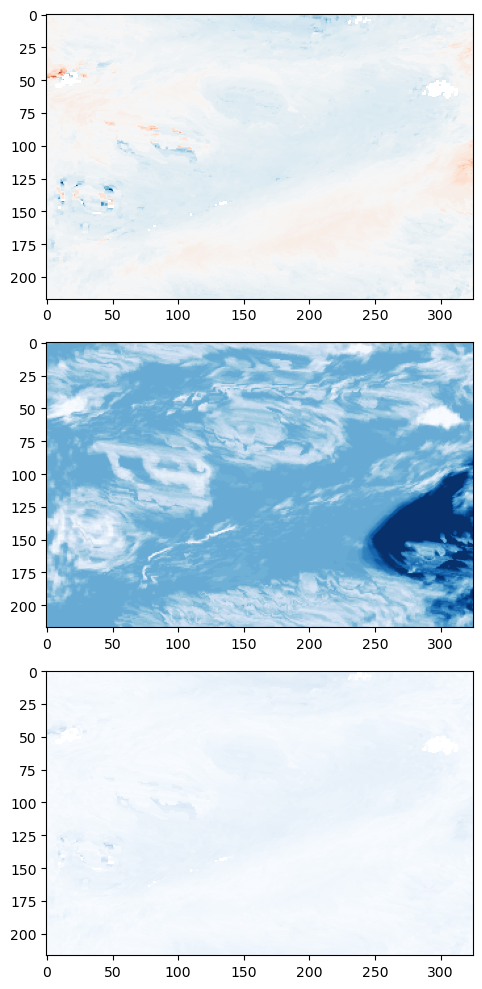

In [36]:
# all years 
f, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].imshow(igram_ds['veloc'].where(igram_ds['coherence'] > 0.5).median(dim='dates'),
         cmap='RdBu', vmin=-0.4, vmax=0.4)
ax[1].imshow(igram_ds['veloc'].where(igram_ds['coherence'] > 0.5).count(dim='dates'), cmap='Blues', vmax=45)
f.tight_layout()
ax[2].imshow(igram_ds['veloc'].where(igram_ds['coherence'] > 0.5).std(dim='dates'), cmap='Blues', vmax=0.4)
f.tight_layout()

In [20]:
# save filtered velocities and counts 
#igram_ds['veloc'].where(igram_ds['coherence'] > 0.5).mean(dim='dates').rio.to_raster('T56D_asc_veloc_mean_0.5coh.tif')

# for some reason these two aren't saving correctly. 
#igram_ds['veloc'].where(igram_ds['coherence'] > 0.5).count(dim='dates').rio.to_raster('T151_asc_veloc_count_0.5coh.tif')
#igram_ds['veloc'].where(igram_ds['coherence'] > 0.5).count(dim='dates').rio.to_raster('T151_asc_veloc_std_0.5coh.tif')

### mean veloc in feature

In [19]:
# load json of aoi 
#aoi_fn = '/home/jovyan/rmnp_landslide/moving_area.shp'
#aoi_gdf = gpd.read_file(aoi_fn)

In [18]:
#igram_aoi = igram_ds.rio.clip(aoi_gdf.geometry, crs=aoi_gdf.crs, drop=False)

In [26]:
# mean velocity
np.nanmean(igram_aoi['veloc'].where(igram_ds['coherence'] > 0.5).values.ravel())

0.018484086612228997

In [27]:
# velocity std dev
np.nanstd(igram_aoi['veloc'].where(igram_ds['coherence'] > 0.5).values.ravel())

0.04788831691302266

In [28]:
# max velocity
np.nanmin(igram_aoi['veloc'].where(igram_ds['coherence'] > 0.5).mean(dim='dates').values.ravel())

-0.12960681064712543

In [29]:
# mean coherence
np.nanmean(igram_aoi['coherence'].values.ravel())

0.21559548

In [30]:
# average number of ints used to calculate velocities
temp = igram_aoi['veloc'].where(igram_ds['coherence'] > 0.5).count(dim='dates')
np.nanmean(temp.where(temp != 0))

11.86984126984127

## filter by coherence area surrounding aoi

In [45]:
# load json of aoi 
#aoi_area_fn = '/home/jovyan/rmnp_landslide/feature_area.shp'
#aoi_area_gdf = gpd.read_file(aoi_area_fn)

In [44]:
# clip to aoi
#igram_ds_aoi_area = igram_ds.rio.clip(aoi_area_gdf.geometry, crs=aoi_area_gdf.crs, drop=False)

In [66]:
igram_high_coh = igram_ds.sel(dates=igram_ds_aoi_area.coherence.median(dim=('x', 'y')) > 0.6)

In [67]:
igram_high_coh

<xarray.Dataset>
Dimensions:      (x: 325, y: 217, dates: 13)
Coordinates:
    band         int64 2
  * x            (x) float64 -105.7 -105.7 -105.7 ... -105.7 -105.7 -105.7
  * y            (y) float64 40.31 40.31 40.31 40.31 ... 40.29 40.29 40.29 40.29
    spatial_ref  int64 0
  * dates        (dates) <U17 '20150724-20150817' ... '20180825-20180906'
Data variables:
    unw_phase    (dates, y, x) float64 -0.04888 -0.04888 ... 2.907 2.907
    coherence    (dates, y, x) float32 0.9146 0.9146 0.6955 ... 0.4149 0.4149
    veloc        (y, x, dates) float64 -0.003281 -0.003281 ... 0.003316 0.006632
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

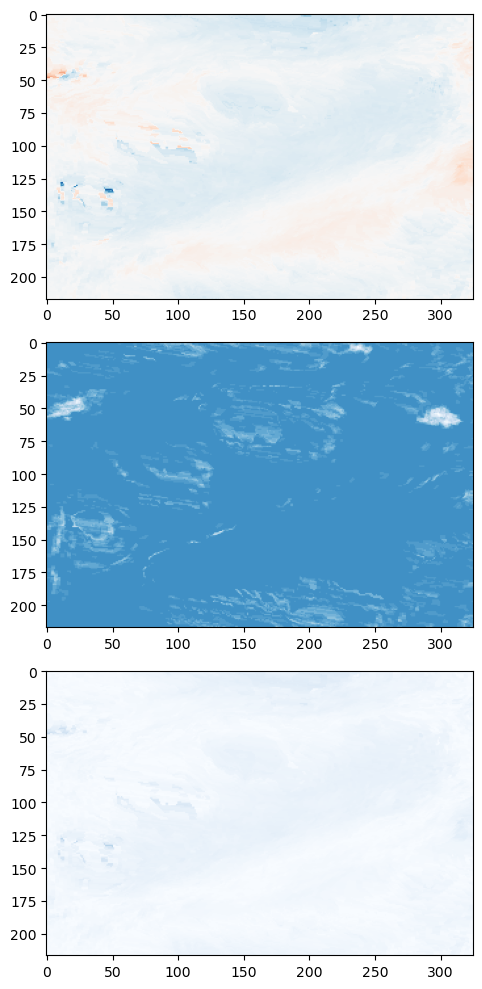

In [69]:
f, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].imshow(igram_high_coh['veloc'].where(igram_ds['coherence'] > 0.3).median(dim='dates'),
         cmap='RdBu', vmin=-0.4, vmax=0.4)
ax[1].imshow(igram_high_coh['veloc'].where(igram_ds['coherence'] > 0.3).count(dim='dates'), cmap='Blues', vmax=20)
f.tight_layout()
ax[2].imshow(igram_high_coh['veloc'].where(igram_ds['coherence'] > 0.3).std(dim='dates'), cmap='Blues', vmax=0.4)
f.tight_layout()

In [75]:
igram_ds.to_netcdf("DT56_ds.nc")

In [71]:
ds_disk = xr.open_dataset("DT56_ds.nc")

## Make igram baseline figure

In [31]:
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime(year=year, month=1, day=1)
    startOfNextYear = datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [32]:
lines = []
for i, date in enumerate(igram_ds['dates'].values):
    lines.append([(toYearFraction(datetime.strptime(date[0:8], '%Y%m%d')), i), (toYearFraction(datetime.strptime(date[9:17], '%Y%m%d')), i)])

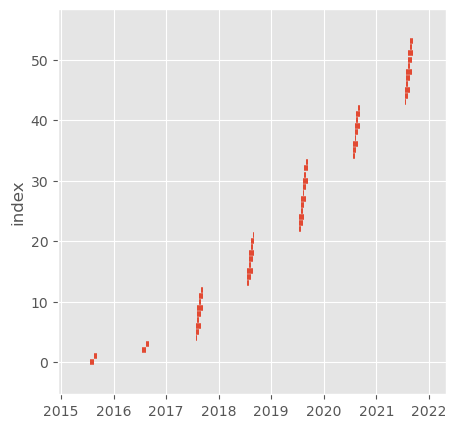

In [34]:
lc = mc.LineCollection(lines, linewidths=4)

plt.style.use('ggplot')
f, ax = plt.subplots(figsize=(5, 5))
ax.add_collection(lc)
ax.margins(0.1)
ax.set_ylabel('index')

plt.savefig('tbline_T56D.png', dpi=300)

In [35]:
print(f'mean tbaseline: {np.mean(delta_list)} days, max tbaseline: {np.max(delta_list)} days, min tbaseline: {np.min(delta_list)} days')

mean tbaseline: 22.0 days, max tbaseline: 36 days, min tbaseline: 12 days


In [ ]:
# interferogram length capped at 40 days to avoid decorrelation
# mean interferogram length: 21.8 days, max length: 36 days, min length: 12 days